In [7]:
# --- Install dependencies ---
!pip install joblib pandas numpy matplotlib pyarrow scikit-learn --quiet

In [8]:
# --- Imports ---
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import os
import re

In [9]:
# Load your engineered dataset
df = pd.read_parquet("/content/engineered_features.parquet")

# Use cleaned text column
texts = df["clean_text"].astype(str).tolist()

# Optional: load structured feature names
structured_features = joblib.load("/content/feature_names.json")
X_structured = df[structured_features].values

# Tokenize text
tokenized_texts = [text.split() for text in texts]
joblib.dump(tokenized_texts, "/content/tokenized_texts.pkl")

print(f" Loaded {len(tokenized_texts)} tokenized reviews.")

 Loaded 9480 tokenized reviews.


In [10]:
# Define identity functions to avoid PicklingError with lambdas
def identity(x):
    return x

# Build CountVectorizer using identity functions
vectorizer = CountVectorizer(
    tokenizer=identity,
    preprocessor=identity,
    max_features=10000
)

# Convert tokenized texts to a bag-of-words matrix
X_counts = vectorizer.fit_transform(tokenized_texts)

# Reduce dimensionality to 100 dimensions (similar to Word2Vec vectors)
svd = TruncatedSVD(n_components=100, random_state=42)
X_w2v_like = svd.fit_transform(X_counts)

# Save Word2Vec-like embeddings and models
np.save("/content/X_word2vec.npy", X_w2v_like)
joblib.dump(vectorizer, "/content/word2vec_vectorizer.pkl")
joblib.dump(svd, "/content/word2vec_svd.pkl")

print("Word2Vec-like embeddings created and saved (X_word2vec.npy)")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Word2Vec-like embeddings created and saved (X_word2vec.npy)


In [11]:
glove_path = "/content/glove.6B.100d.txt"

# Download GloVe file if not already present
if not os.path.exists(glove_path):
    print("  Downloading GloVe embeddings (6B, 100d)...")
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip -d /content/
    print(" GloVe downloaded and extracted.")

# Load GloVe vectors into a dictionary
glove_embeddings = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vector = np.array(parts[1:], dtype="float32")
        glove_embeddings[word] = vector

print(f" Loaded {len(glove_embeddings):,} GloVe word vectors.")

 GloVe downloaded and extracted.
 Loaded 400,000 GloVe word vectors.


In [12]:
# Helper function to compute average embedding per review
def get_glove_vector(tokens, embeddings, dim=100):
    vectors = [embeddings[word] for word in tokens if word in embeddings]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

# Compute GloVe embeddings for each review
X_glove = np.array([get_glove_vector(tokens, glove_embeddings) for tokens in tokenized_texts])

In [13]:
# Save outputs
np.save("/content/X_glove.npy", X_glove)
joblib.dump(glove_embeddings, "/content/glove_embeddings.pkl")

print("GloVe embeddings created and saved (X_glove.npy)")

GloVe embeddings created and saved (X_glove.npy)


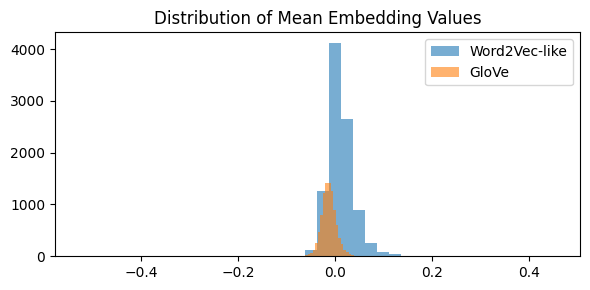

 Embedding process completed successfully!


In [14]:
plt.figure(figsize=(6, 3))
plt.hist(np.mean(X_w2v_like, axis=1), bins=40, alpha=0.6, label="Word2Vec-like")
plt.hist(np.mean(X_glove, axis=1), bins=40, alpha=0.6, label="GloVe")
plt.title("Distribution of Mean Embedding Values")
plt.legend()
plt.tight_layout()
plt.show()

print(" Embedding process completed successfully!")